In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from collections import Counter
import sklearn.ensemble as ske
import seaborn as sns
from imblearn.over_sampling import SMOTE
import gc
%matplotlib inline

In [2]:
sns.set_style("whitegrid")
gc.enable()

In [3]:
# Removes a warning in sklearn that will be fixed during an update mid 2018
import warnings

if __name__ == '__main__':
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    le = preprocessing.LabelEncoder()
    le.fit([1, 2, 2, 6])
    le.transform([1, 1, 2, 6])
    le.inverse_transform([0, 0, 1, 2])

In [48]:
buro_bal = pd.read_csv('./data/bureau_balance.csv')
print('Buro bal shape : ', buro_bal.shape)

print('transform to dummies')
buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)

print('Counting buros')
buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])

print('averaging buro bal')
avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()

avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
del buro_bal
gc.collect()

print('Read Bureau')
buro = pd.read_csv('./data/bureau.csv')

print('Go to dummies')
buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')

buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
# buro_full.columns = ['buro_' + f_ for f_ in buro_full.columns]

del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
gc.collect()

print('Merge with buro avg')
buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))

print('Counting buro per SK_ID_CURR')
nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])

print('Averaging bureau')
avg_buro = buro_full.groupby('SK_ID_CURR').mean()

del buro, buro_full
gc.collect()

print('Read prev')
prev = pd.read_csv('./data/previous_application.csv')

prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]

print('Go to dummies')
prev_dum = pd.DataFrame()
for f_ in prev_cat_features:
    prev_dum = pd.concat([prev_dum, pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)], axis=1)

prev = pd.concat([prev, prev_dum], axis=1)

del prev_dum
gc.collect()

print('Counting number of Prevs')
nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])

print('Averaging prev')
avg_prev = prev.groupby('SK_ID_CURR').mean()
del prev
gc.collect()

print('Reading POS_CASH')
pos = pd.read_csv('./data/POS_CASH_balance.csv')

print('Go to dummies')
pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)

print('Compute nb of prevs per curr')
nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Go to averages')
avg_pos = pos.groupby('SK_ID_CURR').mean()

del pos, nb_prevs
gc.collect()

print('Reading CC balance')
cc_bal = pd.read_csv('./data/credit_card_balance.csv')

print('Go to dummies')
cc_bal = pd.concat([cc_bal, pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)

nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Compute average')
avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]

del cc_bal, nb_prevs
gc.collect()

print('Reading Installments')
inst = pd.read_csv('./data/installments_payments.csv')
nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

avg_inst = inst.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]

print('Read data and test')
data = pd.read_csv('./data/application_train.csv')
test = pd.read_csv('./data/application_test.csv')
print('Shapes : ', data.shape, test.shape)

categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]
categorical_feats
for f_ in categorical_feats:
    data[f_], indexer = pd.factorize(data[f_])
    test[f_] = indexer.get_indexer(test[f_])
    
data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')

train = data

del avg_buro, avg_prev
gc.collect()


Buro bal shape :  (27299925, 3)
transform to dummies
Counting buros
averaging buro bal
Read Bureau
Go to dummies
Merge with buro avg
Counting buro per SK_ID_CURR
Averaging bureau
Read prev
Go to dummies
Counting number of Prevs
Averaging prev
            SK_ID_PREV  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  \
SK_ID_CURR                                                         
100001             1.0     3951.000         24835.50    23787.00   
100002             1.0     9251.775        179055.00   179055.00   
100003             3.0    56553.990        435436.50   484191.00   
100004             1.0     5357.250         24282.00    20106.00   
100005             2.0     4813.200         22308.75    20076.75   

            AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                               
100001                2520.0          24835.5                13.000000   
100002                   0.0         179055.0             

142

In [49]:
train.to_csv('./data/created/train_revised.csv', sep=',', index=False)
test.to_csv('./data/created/test_revised.csv', sep=',', index=False)

In [71]:
#train, test = read_and_merge_data()
train = pd.read_csv('./data/created/train_revised.csv', sep=',', header=0)
test = pd.read_csv('./data/created/test_revised.csv', sep=',', header=0)

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['TARGET'], axis=1, inplace=True)

print("train size is : {}".format(train.shape))
print("test size is : {}".format(test.shape))
print("all_data size is : {}".format(all_data.shape))

train size is : (307511, 381)
test size is : (48744, 380)
all_data size is : (356255, 380)


In [54]:
def plot_missing_ratio(df):
    missing = (df.isnull().sum() / len(df)) * 100
    missing = missing.drop(missing[missing == 0].index).sort_values(ascending=False)

    missing_ratio = pd.DataFrame({'Missing Ratio' :missing})

    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=missing.index, y=missing, )
    
    if (len(df.columns) > 100):
        ax.get_xaxis().set_visible(False)
        
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Percent of missing values', fontsize=10)
    plt.title('Percent missing data by feature', fontsize=10)

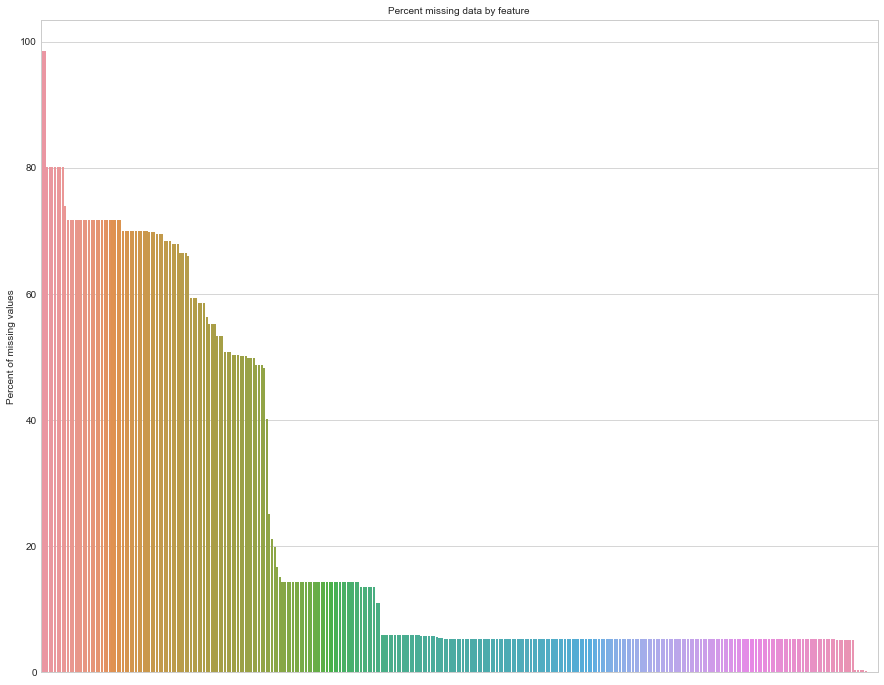

In [55]:
plot_missing_ratio(all_data)

In [4]:
categorical_columns = ['NAME_CONTRACT_TYPE',
                       'CODE_GENDER',
                       'FLAG_OWN_CAR',
                       'FLAG_OWN_REALTY',
                       'NAME_TYPE_SUITE',
                       'NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE',
                       'NAME_FAMILY_STATUS',
                       'NAME_HOUSING_TYPE',
                       'OCCUPATION_TYPE',
                       'WEEKDAY_APPR_PROCESS_START',
                       'ORGANIZATION_TYPE',
                       'FONDKAPREMONT_MODE',
                       'HOUSETYPE_MODE',
                       'WALLSMATERIAL_MODE',
                       'EMERGENCYSTATE_MODE']

In [5]:
def replace_few_missing_with_default(df, max_ratio=5):

    missing = (df.isnull().sum() / len(df)) * 100
    missing = missing.drop(missing[missing == 0].index)
    few_missing = missing.drop(missing[missing > max_ratio].index)

    few_missing_columns = few_missing.index

    for col in few_missing_columns:
        df[col].fillna(df[col].value_counts().index[0], inplace = True)

    return df

In [6]:
def replace_missing(df, categorical_columns):
    
    numeric_columns = list(df.select_dtypes(include=[np.number]).columns.values)
    
    df = replace_few_missing_with_default(df)
    df[categorical_columns] = df[categorical_columns].fillna("UNKNOWN") 
    
    """for col in categorical_columns:
        if col in numeric_columns:
            df[col] = df[col].fillna(-999) 
        else:
            df[col] = df[col].fillna("UNKNOWN") """
    
    # Replace numeric values with mean
    for col in numeric_columns:
        if df[col].dtype == np.int:
            df[col].fillna((df[col].median()), inplace = True) 
        else:
            df[col].fillna((df[col].mean()), inplace = True)   
            
    return df

In [8]:
print("Number of columns with missing data: " + str(len(all_data.columns[all_data.isnull().any()].tolist())))
all_data = replace_missing(all_data, categorical_columns)
print("Number of columns with missing data: " + str(len(all_data.columns[all_data.isnull().any()].tolist())))

Number of columns with missing data: 144
Number of columns with missing data: 0


In [7]:
def process_categorical(df, categorical_columns):
    
    # Significance of categories for target, will later try more with this
    #for col in categorical_columns:
    #   df.groupby(col).mean()['TARGET'].sort_values(ascending=False)

    df[categorical_columns] = df[categorical_columns].apply(preprocessing.LabelEncoder().fit_transform)
    df[categorical_columns] = df[categorical_columns].astype(str)
    df = pd.get_dummies(df)
    
    return df

In [10]:
df_all = process_categorical(all_data, categorical_columns)
df_all.head(1)

,AMT_ANNUITY,AMT_ANNUITY_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,WALLSMATERIAL_MODE_5,WALLSMATERIAL_MODE_6,WALLSMATERIAL_MODE_7,WEEKDAY_APPR_PROCESS_START_0,WEEKDAY_APPR_PROCESS_START_1,WEEKDAY_APPR_PROCESS_START_2,WEEKDAY_APPR_PROCESS_START_3,WEEKDAY_APPR_PROCESS_START_4,WEEKDAY_APPR_PROCESS_START_5,WEEKDAY_APPR_PROCESS_START_6
0,9251.775,24700.5,0.0,179055.0,69973.192455,207320.669739,1681.029,108131.945625,49156.2,7997.14125,...,1,0,0,0,0,0,0,0,0,1


In [8]:
def rescale_data(df, mode='norm'):
    scalable_columns = list(df.select_dtypes(include=[np.float]))
    
    if mode=='norm':
        df[scalable_columns] = (df[scalable_columns] - np.min(df[scalable_columns])) \
                                / (np.max(df[scalable_columns]) - np.min(df[scalable_columns]))
    elif mode=='stand':
        df[scalable_columns] = (df[scalable_columns] - np.mean(df[scalable_columns])) \
                                / np.std(df[scalable_columns])
    return df

In [12]:
df_all = rescale_data(df_all)
df_all.select_dtypes(include=[np.float]).head(1)

,AMT_ANNUITY,AMT_ANNUITY_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,SK_DPD_DEF_y,SK_DPD_x,SK_DPD_y,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,0.030796,0.090032,0.0,0.044211,0.078255,0.153571,0.000014,0.000546,0.02144,0.02303,...,0.000093,0.0,0.002511,0.0149,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341


In [9]:
def detect_outliers(df, n, features):
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = df[col].quantile(.25)
        # 3rd quartile (75%)
        Q3 = df[col].quantile(.75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [12]:
def downsample_outliers(df, outliers):
    
    outlier_df = df.iloc[outliers]
    outlier_df[(outlier_df['TARGET'] == 0)]
    negative_outliers = list(outlier_df.index)
    
    df = df.drop(negative_outliers).reset_index(drop=True)
    
    return df

In [78]:
float_columns = list(train.select_dtypes(include=[np.float]).columns.values)
outlier_rows = detect_outliers(train, 43, float_columns)
print('Number of outliers found: ' + str(len(outlier_rows)))

Number of outliers found: 522


In [52]:
print(train.shape)
train = downsample_outliers(train, outlier_rows)
print(train.shape)

(307511, 381)
(300994, 381)


In [10]:
def preprocess_data(df, categorical_columns):
    
    df = replace_missing(df, categorical_columns)
    df = process_categorical(df, categorical_columns)
    df = rescale_data(df)
    df = df.drop('SK_ID_CURR', axis=1)
    
    return df

In [25]:
train = pd.read_csv('./data/created/train_revised.csv', sep=',', header=0)
test = pd.read_csv('./data/created/test_revised.csv', sep=',', header=0)

print('Training set shape before removing outliers: ' + str(train.shape))
float_columns = list(train.select_dtypes(include=[np.float]).columns.values)
outlier_rows = detect_outliers(train, 43, float_columns)
train = downsample_outliers(train, outlier_rows)

m_train = train.shape[0]
m_test = test.shape[0]
y = train['TARGET']
train.drop(['TARGET'], axis=1, inplace=True)

ids = test['SK_ID_CURR']

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data = preprocess_data(all_data, categorical_columns)

train = all_data.loc[0:m_train-1].copy()
test = all_data.loc[m_train:].copy()

train['TARGET'] = y

print('Training set shape: ' + str(train.shape))
print('Test set shape: ' + str(test.shape))

print("Number of columns with missing data: " + str(len(all_data.columns[all_data.isnull().any()].tolist())))

all_data.head(1)

Training set shape before removing outliers: (307511, 381)
Training set shape: (306989, 510)
Test set shape: (48744, 509)
Number of columns with missing data: 0


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_1,WALLSMATERIAL_MODE_2,WALLSMATERIAL_MODE_3,WALLSMATERIAL_MODE_4,WALLSMATERIAL_MODE_5,WALLSMATERIAL_MODE_6,WALLSMATERIAL_MODE_7,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_1,EMERGENCYSTATE_MODE_2
0,0,0.001512,0.090287,0.090032,0.077441,0.256702,-9461,-637,0.85214,-2120,...,1,0,0,0,0,0,0,0,1,0


In [14]:
def split_data(df):
    
    df_train = df.sample(frac = 0.9, random_state = 42)
    df_val = df.drop(df_train.index)  
    
    X_train = df_train.drop(['TARGET'], axis=1).values
    y_train = df_train['TARGET'].values
    
    X_val = df_val.drop(['TARGET'], axis=1).values
    y_val = df_val['TARGET'].values
    
    return X_train, y_train, X_val, y_val

In [15]:
X_train, y_train, X_val, y_val = split_data(train)

In [117]:
def oversample(X, y):
    
    print('Y mean: {0}'.format(np.mean(y)))
    
    sm = SMOTE(random_state=42, out_step=0.2)
    
    X_res, y_res = sm.fit_sample(X, y, )
    
    print('Y oversampled mean: {0}'.format(np.mean(y_res)))
    
    return X_res, y_res

In [118]:
X_train_res, y_train_res = oversample(X_train, y_train)

print('X shape: ' + str(X_train_res.shape))
print('y shape: ' + str(y_train_res.shape))

Y mean: 0.08068695935430165
Y oversampled mean: 0.5
X shape: (507994, 509)
y shape: (507994,)


In [16]:
def train_lgbm_clf(clf, X_train, y_train, X_val, y_val):
    
    clf.fit(X_train, y_train, 
            eval_set= [(X_val, y_val)],
            eval_metric='auc', 
            verbose=250, 
            early_stopping_rounds=150
           )
    
    y_act, y_pred = y_val, clf.predict(X_val)
    scores = cross_val_score(clf, X_val, y_val, cv=10, scoring='roc_auc')
    print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    
    return clf

In [20]:
lgbm_clf = LGBMClassifier(nthread=4,
                          n_estimators=10000,
                          learning_rate=0.03,
                          num_leaves=34,
                          colsample_bytree=0.9497036,
                          subsample=0.8715623,
                          max_depth=8,
                          reg_alpha=0.041545473,
                          reg_lambda=0.0735294,
                          min_split_gain=0.0222415,
                          min_child_weight=39.3259775,
                          silent=-1,
                          verbose=-1,)

lgbm_clf = train_lgbm_clf(lgbm_clf, X_train, y_train, X_val, y_val)

Training until validation scores don't improve for 150 rounds.
[250]	valid_0's auc: 0.767845
[500]	valid_0's auc: 0.775832
[750]	valid_0's auc: 0.77816
[1000]	valid_0's auc: 0.779002
[1250]	valid_0's auc: 0.779445
[1500]	valid_0's auc: 0.779643
[1750]	valid_0's auc: 0.779666
Early stopping, best iteration is:
[1648]	valid_0's auc: 0.779905
Validation Accuracy: 0.71 (+/- 0.02)


In [21]:
def predict(df, ids, clf, export_path):
    
    # Make predictions
    X = df.values
    y = clf.predict_proba(X, num_iteration=clf.best_iteration_)[:, 1]
    
    # Combine ids and predictions
    y = np.column_stack((ids, y))
    
    # Restore pandas df
    pred = pd.DataFrame(y)
    pred.columns = ["SK_ID_CURR", "TARGET"]
    
    pred["SK_ID_CURR"] = pred["SK_ID_CURR"].astype('int64')
    
    # Export
    pred.to_csv(export_path, sep=',', index=False)
    
    return pred

In [22]:
#df_test = pd.read_csv('./data/application_test.csv', sep=',', header=0)
#df_pred = predict(df_test, rf_clf, categorical_columns, './predictions/rf_pred.csv')
pred = predict(test, ids, lgbm_clf, './predictions/lgbm_pred.csv')

In [ ]:
def train_model(train_, test_, y_, folds_):

    oof_preds = np.zeros(train_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in train_.columns if f not in ['SK_ID_CURR']]
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(train_)):
        trn_x, trn_y = train_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = train_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.03,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
               )
        
        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['TARGET'] = sub_preds

    return oof_preds, test_[['TARGET']], feature_importance_df

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=1337)

y = train['TARGET']
train.drop(['TARGET'], axis=1, inplace=True)

oof_preds, test_preds, importances = train_model(train, test, y, folds)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.7596	valid_1's auc: 0.757426
[200]	training's auc: 0.791861	valid_1's auc: 0.778555
[300]	training's auc: 0.808203	valid_1's auc: 0.785549
[400]	training's auc: 0.820324	valid_1's auc: 0.788281
[500]	training's auc: 0.830441	valid_1's auc: 0.789812
[600]	training's auc: 0.839234	valid_1's auc: 0.79039
[700]	training's auc: 0.847505	valid_1's auc: 0.790777
Early stopping, best iteration is:
[698]	training's auc: 0.847315	valid_1's auc: 0.790799
Fold  1 AUC : 0.790799
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.763232	valid_1's auc: 0.741797
[200]	training's auc: 0.795007	valid_1's auc: 0.7635
[300]	training's auc: 0.811197	valid_1's auc: 0.770294
[400]	training's auc: 0.822802	valid_1's auc: 0.773166
[500]	training's auc: 0.832799	valid_1's auc: 0.774517
[600]	training's auc: 0.841525	valid_1's auc: 0.775093
[700]	training's auc: 0.849225	valid_1's auc: 0.775

In [ ]:
y_pred = test_preds.values
ids_pred = ids.values
pred = np.column_stack((ids_pred, y_pred))
pred = pd.DataFrame(pred)
pred.columns = ["SK_ID_CURR", "TARGET"]
pred["SK_ID_CURR"] = pred["SK_ID_CURR"].astype('int64')
pred.to_csv('./predictions/lgbm_pred.csv', index=False)

In [ ]:
pred.head(3)

In [50]:
pred.head(3)

,SK_ID_CURR,TARGET
0,100001,0.027959
1,100005,0.133590
2,100013,0.024429
